In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2

%matplotlib inline 

In [3]:
df_all = pd.read_pickle(os.path.join(os.getcwd(), 'input\LSWMD.pkl'))
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df_all['failureNum'] = df_all.failureType
df_all['trainTestNum'] = df_all.trianTestLabel

mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,
              'Edge-Ring':3,'Loc':4,'Random':5,
              'Scratch':6,'Near-full':7,'none':8}

mapping_traintest = {'Training':0, 'Test':1}

df_all = df_all.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\pandas\core\internals.py:5152: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(a, b)
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\pandas\core\missing.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [5]:
df_withlabel = df_all[(df_all['failureNum'] >= 0) & df_all['failureNum'] <=8]
df_withlabel = df_withlabel.reset_index()

df_withpattern = df_all[(df_all['failureNum'] >= 0) & (df_all['failureNum'] <= 7)]
df_withpattern = df_withpattern.reset_index()

df_nopattern = df_all[(df_all['failureNum'] == 8)]

df_withlabel.shape, df_withpattern.shape, df_nopattern.shape

((811457, 9), (25519, 9), (147431, 8))

In [54]:
test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

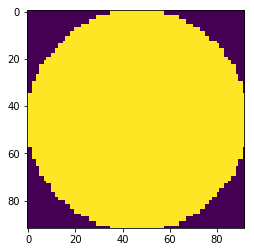

In [55]:
plt.imshow(test)

In [79]:
## индкы поля для синтеза кривых
i, j = np.where(test==1)

In [67]:
def make_bezier(xys):
    # xys should be a sequence of 2-tuples (Bezier control points)
    n = len(xys)
    combinations = pascal_row(n-1)
    def bezier(ts):
        # This uses the generalized formula for bezier curves
        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization
        result = []
        for t in ts:
            tpowers = (t**i for i in range(n))
            upowers = reversed([(1-t)**i for i in range(n)])
            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]
            result.append(
                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))
        return result
    return bezier

def pascal_row(n):
    # This returns the nth row of Pascal Triangle
    result = [1]
    x, numerator = 1, n
    for denominator in range(1, n//2+1):
        # print(numerator,denominator,x)
        x *= numerator
        x /= denominator
        result.append(x)
        numerator -= 1
    if n&1 == 0:
        # n is even
        result.extend(reversed(result[:-1]))
    else:
        result.extend(reversed(result)) 
    return result

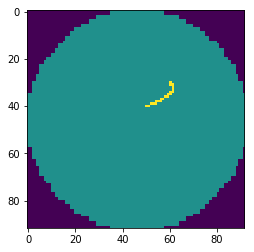

In [107]:
test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

ts = [t/100.0 for t in range(0, 101)]
xys = [(30, 60), (35, 64), (40, 50)]
bezier = make_bezier(xys)
points = bezier(ts)

for idx in points:
    i, j = idx
    i = round(i)
    j = round(j)
    test[i, j] = 2
    
plt.imshow(test)